### 问题3： 教练们很想知道是否有一些指标可以帮助确定何时 比赛流程即将从有利于一名球员转变为另一名球员。 o 使用至少一场比赛提供的数据，开发一个模型来预测比赛中的这些波动。哪 些因素似乎最相关(如果有的话)? o 考虑到过去比赛中“动量”波动的差异，你如何建议一名球员进入一场与不同球员的新比赛?

#### 基于问题1提出的模型，我们可以知道对于每一个比分的预测是非常困难的，如果能够在总体上（即对于每一个game）能够判断是否获得胜利，同样是非常有价值的，因此，我们在问题1模型基础上对数据进行聚合，每一条样本表示的内容为一场game的信息，label即为对于当前game对局是否获得胜利。

剔除了得分异常的样本,删除了配速有缺失的样本

In [51]:
import pandas as pd
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
df = pd.read_csv('Wimbledon_featured_matches.csv')
df.loc[(df.p1_score=='AD'),'p1_score'] = 50
df.loc[(df.p2_score=='AD'),'p2_score'] = 50
df['p1_score'] = df['p1_score'].astype(int)
df['p2_score'] = df['p2_score'].astype(int)

df.dropna(subset=['speed_mph'],inplace=True)

In [52]:
code = []

s1_ls,s2_ls,s3_ls,s4_ls,s5_ls,s6_ls,s7_ls,s8_ls,s9_ls,s10_ls,s11_ls,\
s12_ls,s13_ls,s14_ls,s15_ls,s16_ls=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
label_ls = []
for match_id in df.match_id.unique():
    t = df[df.match_id==match_id]
    for set_no in t.set_no.unique():
        t2 = t[t.set_no==set_no]
        for game_no in t2.game_no.unique():
            t3 = t2[t2.game_no==game_no]
            if t3['game_victor'].values[-1] == 1:
                label_ls.append(1)
            else:
                label_ls.append(0)
len(label_ls)

1108

In [53]:
code = []

s1_ls,s2_ls,s3_ls,s4_ls,s5_ls,s6_ls,s7_ls,s8_ls,s9_ls,s10_ls,s11_ls,\
s12_ls,s13_ls,s14_ls,s15_ls,s16_ls=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
label_ls = []
for match_id in df.match_id.unique():
    t = df[df.match_id==match_id]
    for set_no in t.set_no.unique():
        t2 = t[t.set_no==set_no]
        for game_no in t2.game_no.unique():
            t3 = t2[t2.game_no==game_no]
            if t3['game_victor'].values[-1] == 1:
                label_ls.append(1)
            else:
                label_ls.append(0)
for match_id,set_no,game_no,point_no in zip(df.match_id,df.set_no,df.game_no,df.point_no):
    code.append(f'{match_id}-{set_no}-{game_no}')
    match = df[df.match_id==match_id]
    set_ = match[match.set_no==set_no]
    game_ = set_[set_.game_no==game_no]
    point_ = game_[game_.point_no==point_no]
    s1 = point_['p1_games'].values[0]
    s2 = point_['p1_score'].values[0] - point_['p2_score'].values[0]
    s3 = 1 if point_['serve_no'].values[0] == 1 else 0
    s4 = 0 if s2<0 else 1
    s5 = point_['p1_sets'].values[0] - point_['p2_sets'].values[0]
    s6 = 1 if 1 in game_['p1_ace'].values else 0
    s7 = 1 if 1 in game_['p1_winner'].values else 0
    s8 = 1 if 1 in game_['p1_double_fault'].values else 0
    s9 = 1 if 1 in game_['p1_unf_err'].values else 0
    s10 = game_['p1_net_pt_won'].sum()/game_['p1_net_pt'].sum() if game_['p1_net_pt'].sum()!= 0 else 0
    s11 = set_['p1_break_pt_won'].sum()/set_['p1_break_pt'].sum() if game_['p1_break_pt'].sum()!= 0 else 0

    index = match.index.tolist().index(point_.index.tolist()[0])
    s12 = match.iloc[:index+1]['p1_distance_run'].sum()
    s13 = match.iloc[index-2:index+1]['p1_distance_run'].sum()
    s14 = point_['p1_distance_run'].values[0]
    s15 = point_['speed_mph'].values[0]
    s16 = s15*s3
    
    s1_ls.append(s1)
    s2_ls.append(s2)
    s3_ls.append(s3)
    s4_ls.append(s4)
    s5_ls.append(s5)
    s6_ls.append(s6)
    s7_ls.append(s7)
    s8_ls.append(s8)
    s9_ls.append(s9)
    s10_ls.append(s10)
    s11_ls.append(s11)
    s12_ls.append(s12)
    s13_ls.append(s13)
    s14_ls.append(s14)
    s15_ls.append(s15)
    s16_ls.append(s16)
    
dataset = pd.DataFrame({'s1':s1_ls,'s2':s2_ls,'s3':s3_ls,'s4':s4_ls,'s5':s5_ls,'s6':s6_ls,'s7':s7_ls,'s8':s8_ls,'s9':s9_ls,'s10':s10_ls,'s11':s11_ls,'s12':s12_ls,'s13':s13_ls,'s14':s14_ls,'s15':s15_ls,'s16':s16_ls})
dataset['game_code'] = code
dataset

s1  s2  s3  s4  s5  s6  s7  s8  s9  s10  s11       s12     s13     s14  \
0      0   0   0   1   0   1   1   0   1  1.0  0.0     6.000   0.000   6.000   
1      0 -15   1   0   0   1   1   0   1  1.0  0.0    11.253   0.000   5.253   
2      0   0   1   1   0   1   1   0   1  1.0  0.0    25.053  25.053  13.800   
3      0 -15   1   0   0   1   1   0   1  1.0  0.0    76.161  70.161  51.108   
4      0   0   1   1   0   1   1   0   1  1.0  0.0    76.810  65.557   0.649   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...       ...     ...     ...   
6219   5 -15   1   0   0   0   1   0   1  1.0  0.0  6270.624  49.542  38.620   
6220   5   0   1   1   0   0   1   0   1  1.0  0.0  6288.157  62.925  17.533   
6221   5  15   1   1   0   0   1   0   1  1.0  0.0  6299.039  67.035  10.882   
6222   5   0   1   1   0   0   1   0   1  1.0  0.0  6306.932  36.308   7.893   
6223   5  10   1   1   0   0   1   0   1  1.0  0.0  6324.743  36.586  17.811   

        s15    s16                 game_code  
0      95.0    0.0   2023-wimbledon-1301-1-1  
1     118.0  118.0   2023-wimbledon-1301-1-1  
2     120.0  120.0   2023-wimbledon-1301-1-1  
3     130.0  130.0   2023-wimbledon-1301-1-1  
4     112.0  112.0   2023-wimbledon-1301-1-1  
...     ...    ...                       ...  
6219  123.0  123.0  2023-wimbledon-1701-5-10  
6220  114.0  114.0  2023-wimbledon-1701-5-10  
6221  124.0  124.0  2023-wimbledon-1701-5-10  
6222  130.0  130.0  2023-wimbledon-1701-5-10  
6223  129.0  129.0  2023-wimbledon-1701-5-10  

[6224 rows x 17 columns]

#### 按照均值进行聚合

In [54]:
columns = dataset.columns[:-2]

dataset = dataset.groupby('game_code').mean()
dataset['label'] = label_ls
dataset

s1         s2        s3        s4   s5   s6   s7  \
game_code                                                                    
2023-wimbledon-1301-1-1  0.0   0.000000  0.700000  0.800000  0.0  1.0  1.0   
2023-wimbledon-1301-1-2  1.0  -2.500000  0.875000  0.625000  0.0  0.0  0.0   
2023-wimbledon-1301-1-3  1.0  17.000000  0.800000  1.000000  0.0  1.0  1.0   
2023-wimbledon-1301-1-4  2.0 -21.250000  0.750000  0.250000  0.0  0.0  0.0   
2023-wimbledon-1301-1-5  2.0  16.250000  0.625000  1.000000  0.0  0.0  1.0   
...                      ...        ...       ...       ...  ...  ...  ...   
2023-wimbledon-1701-5-5  3.0 -22.000000  0.600000  0.200000  0.0  0.0  0.0   
2023-wimbledon-1701-5-6  3.0  -3.333333  0.500000  0.666667  0.0  1.0  1.0   
2023-wimbledon-1701-5-7  4.0  -6.666667  0.833333  0.500000  0.0  0.0  1.0   
2023-wimbledon-1701-5-8  4.0   5.000000  0.400000  0.800000  0.0  1.0  1.0   
2023-wimbledon-1701-5-9  5.0 -22.000000  0.800000  0.200000  0.0  0.0  0.0   

                          s8   s9  s10  s11          s12        s13  \
game_code                                                             
2023-wimbledon-1301-1-1  0.0  1.0  1.0  0.0    77.577200  39.222300   
2023-wimbledon-1301-1-2  0.0  0.0  0.0  0.0   218.280125  39.420875   
2023-wimbledon-1301-1-3  0.0  0.0  0.0  0.0   290.857000  40.514400   
2023-wimbledon-1301-1-4  0.0  1.0  0.0  0.0   354.968000  38.535250   
2023-wimbledon-1301-1-5  0.0  1.0  1.0  0.0   421.888125  34.142000   
...                      ...  ...  ...  ...          ...        ...   
2023-wimbledon-1701-5-5  0.0  0.0  0.0  0.0  5899.982600  23.636800   
2023-wimbledon-1701-5-6  0.0  0.0  1.0  0.0  5974.278000  38.134833   
2023-wimbledon-1701-5-7  0.0  0.0  0.0  0.0  6053.440167  49.166167   
2023-wimbledon-1701-5-8  0.0  1.0  0.0  0.0  6137.127600  37.625800   
2023-wimbledon-1701-5-9  0.0  0.0  0.0  0.0  6204.257600  40.969800   

                               s14         s15         s16  label  
game_code                                                          
2023-wimbledon-1301-1-1  16.214500  112.400000   82.700000      1  
2023-wimbledon-1301-1-2  11.418375  119.625000  107.500000      0  
2023-wimbledon-1301-1-3  14.444600  119.400000   98.800000      1  
2023-wimbledon-1301-1-4  12.114000  117.250000   90.500000      0  
2023-wimbledon-1301-1-5  11.525375  111.750000   72.500000      1  
...                            ...         ...         ...    ...  
2023-wimbledon-1701-5-5  10.675600  115.000000   73.600000      1  
2023-wimbledon-1701-5-6  10.752667  115.000000   61.666667      0  
2023-wimbledon-1701-5-7  18.016333  115.666667   98.166667      1  
2023-wimbledon-1701-5-8  10.968400  104.400000   45.400000      0  
2023-wimbledon-1701-5-9  13.818800  110.200000   90.400000      1  

[1108 rows x 17 columns]

#### 同样的，对所有特征进行标准化

In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns = dataset.columns[:-1]
scaler.fit(dataset[columns].values)
dataset[columns] = scaler.transform(dataset[columns].values)
dataset.to_excel('Standard_Training_Data.xlsx',index=False)

#### 同样的，为了验证提出的指标对于选手是否获得game胜利是否具有显著影响，我们将数据导入到SPSS中进行二元logist回归分析，判断这些指标的显著性，性能和效果如下

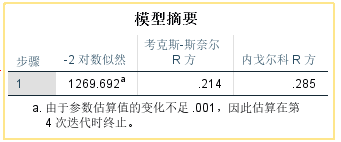
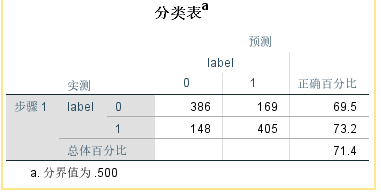
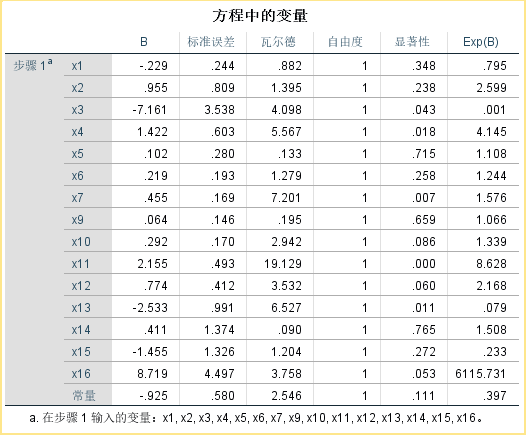

可以看到，二元逻辑回归的准确率在71.4，这对于预测一个选手在实际比赛中能否获得单词game已经非常不错
* 相对于问题1的结果，现有的结果有许多原本不显著的变量也开始显著
#### 额外的，因为二元逻辑回归的性能本身是有限的，我们希望能够选取更加优秀的模型进行预测，所以采用了一些经典的机器学习算法进行对比，使用accuracy、recall、precision、f1和auc进行评价，使用5折交叉验证法进行验证，结果如下:

In [56]:
import warnings
warnings.filterwarnings("ignore")

def function(model):
    auc = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='roc_auc').mean(),2)
    acc = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='accuracy').mean(),2)
    recall = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='recall').mean(),2)
    precision = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='precision').mean(),2)
    f1 = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='f1').mean(),2)
    return acc,recall,precision,f1,auc

model = LGBMClassifier(random_state=30,force_col_wise=True)
a = function(model)
print(f'LGBMClassifier acc,recall,precision,f1,auc :{function(model)}')
model = XGBClassifier(random_state=50)
b = function(model)

print(f'XGBClassifier acc,recall,precision,f1,auc :{function(model)}')
model = SVC(random_state=50)
c = function(model)

print(f'SVC acc,recall,precision,f1,auc :{function(model)}')
model = MLPClassifier(random_state=60)
d = function(model)

print(f'MLPClassifier acc,recall,precision,f1,auc :{function(model)}')
model = LogisticRegression(random_state=50)
e = function(model)
print(f'LogisticRegression acc,recall,precision,f1,auc :{function(model)}')

pd.DataFrame([a,b,c,d,e],columns=['acc','recall','precision','f1','auc'],index=['LGBM','XGB','SVC','MLP','LR']).to_excel('task3_image\\算法对比结果.xlsx')

[LightGBM] [Info] Number of positive: 442, number of negative: 444
[LightGBM] [Info] Total Bins 1430
[LightGBM] [Info] Number of data points in the train set: 886, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498871 -> initscore=-0.004515
[LightGBM] [Info] Start training from score -0.004515
[LightGBM] [Info] Number of positive: 442, number of negative: 444
[LightGBM] [Info] Total Bins 1427
[LightGBM] [Info] Number of data points in the train set: 886, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498871 -> initscore=-0.004515
[LightGBM] [Info] Start training from score -0.004515
[LightGBM] [Info] Number of positive: 442, number of negative: 444
[LightGBM] [Info] Total Bins 1424
[LightGBM] [Info] Number of data points in the train set: 886, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498871 -> initscore=-0.004515
[LightGBM] [Info] Start training from score -0.004515
[LightGBM] [Warning] N

[LightGBM] [Info] Number of positive: 441, number of negative: 445
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1432
[LightGBM] [Info] Number of data points in the train set: 886, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497743 -> initscore=-0.009029
[LightGBM] [Info] Start training from score -0.009029


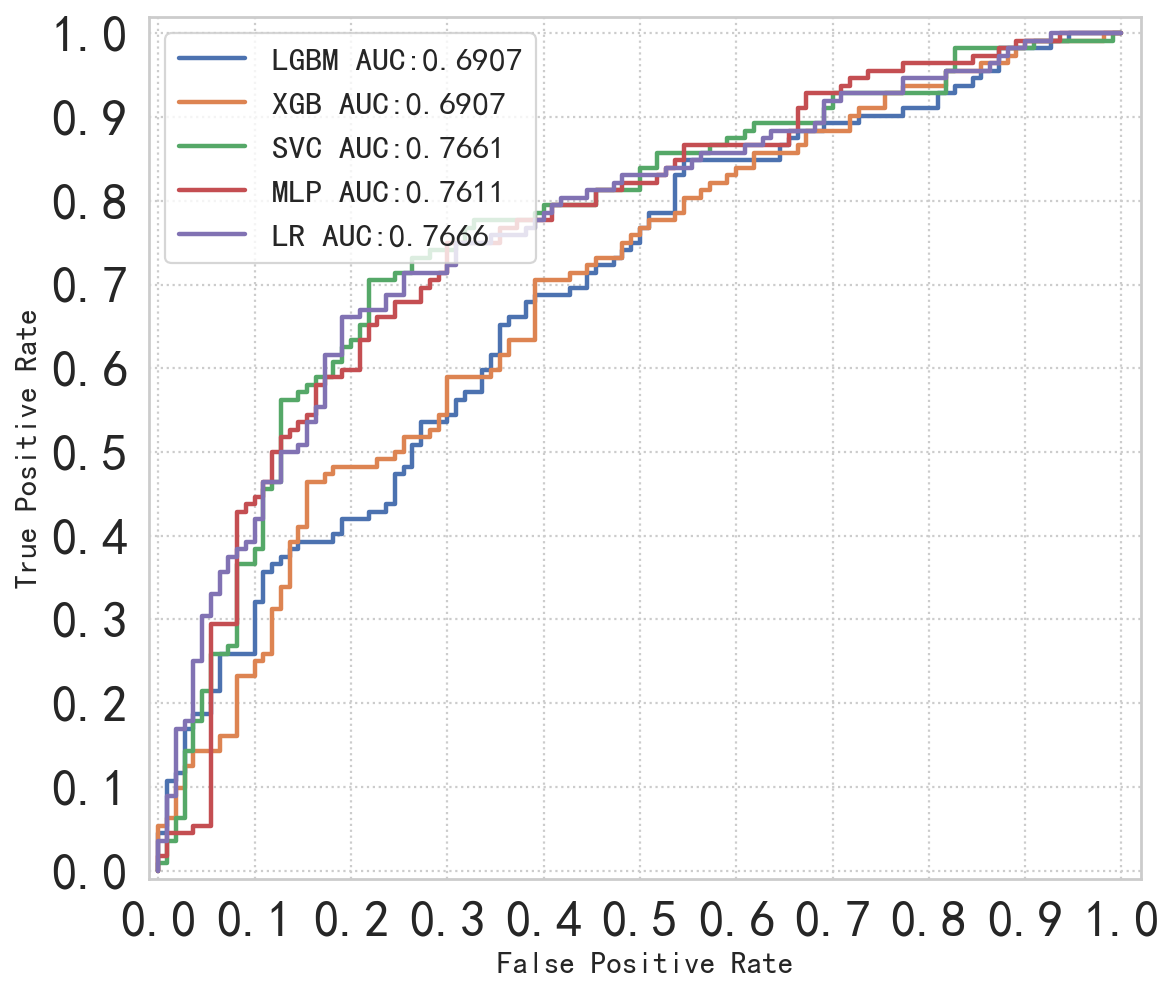

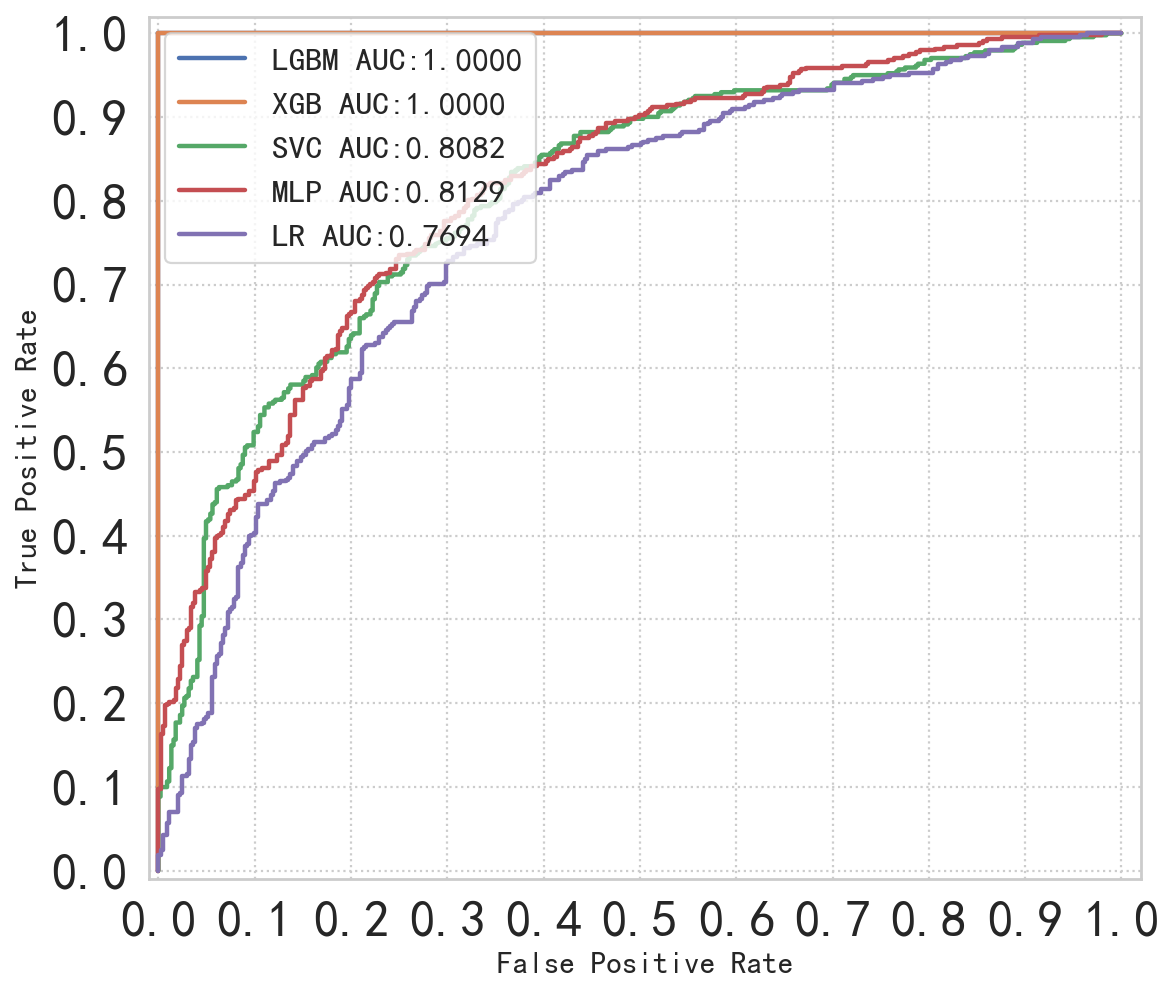

In [57]:
import numpy as np
from sklearn import metrics
def f(model_list,name_list,types='train'):
    plt.figure(figsize=(8, 7), dpi=80, facecolor='w')    # dpi:每英寸长度的像素点数；facecolor 背景颜色
    plt.xlim((-0.01, 1.02))  # x,y 轴刻度的范围
    plt.ylim((-0.01, 1.02))
    plt.xticks(np.arange(0, 1.1, 0.1))  #绘制刻度
    plt.yticks(np.arange(0, 1.1, 0.1))
    
    if types == 'test':
        for model,name in zip(model_list,name_list):
            ytest_prob = model.predict_proba(xvalid)[:,1]
            fpr, tpr, _ = metrics.roc_curve(yvalid, ytest_prob)
            auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, '-', lw=2, label=f'{name} AUC:%.4f' % auc)  # 绘制AUC 曲线
    else:
        for model,name in zip(model_list,name_list):
            ytest_prob = model.predict_proba(xtrain)[:,1]
            fpr, tpr, _ = metrics.roc_curve(ytrain, ytest_prob)
            auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, '-', lw=2, label=f'{name} AUC:%.4f' % auc)  # 绘制AUC 曲线
    plt.legend(loc='upper left',fontsize=15)    # 设置显示标签的位置
    plt.xlabel('False Positive Rate', fontsize=14)   #绘制x,y 坐标轴对应的标签
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.tick_params(labelsize=23)

    plt.grid(True, ls=':')  # 绘制网格作为底板;b是否显示网格线；ls表示line style
    #plt.savefig(f'task3_image\\roc_auc({types}(before_sampling_t3)).png',dpi=500)
    plt.show()
    

xtrain, xvalid, ytrain, yvalid = train_test_split(dataset[columns].values,dataset['label'].values,random_state=620,test_size=0.2)

model1 = LGBMClassifier(random_state=30)
model2 = XGBClassifier(random_state=50)
model3 = SVC(probability=True,random_state=50)
model4 = MLPClassifier(random_state=60)
model5 = LogisticRegression(random_state=50)

model1.fit(xtrain,ytrain)
model2.fit(xtrain,ytrain)
model3.fit(xtrain,ytrain)
model4.fit(xtrain,ytrain)
model5.fit(xtrain,ytrain)

f([model1,model2,model3,model4,model5],['LGBM','XGB','SVC','MLP','LR'],'test')
f([model1,model2,model3,model4,model5],['LGBM','XGB','SVC','MLP','LR'],'train')


对于单次game的预测，我们可以发现传统的机器学习模型相对于树模型有更好的表现，其中，表现最好的应该是SVC，因为它的f1得分最高，意味着对所有样本的预测能够兼顾到每个类别的样本

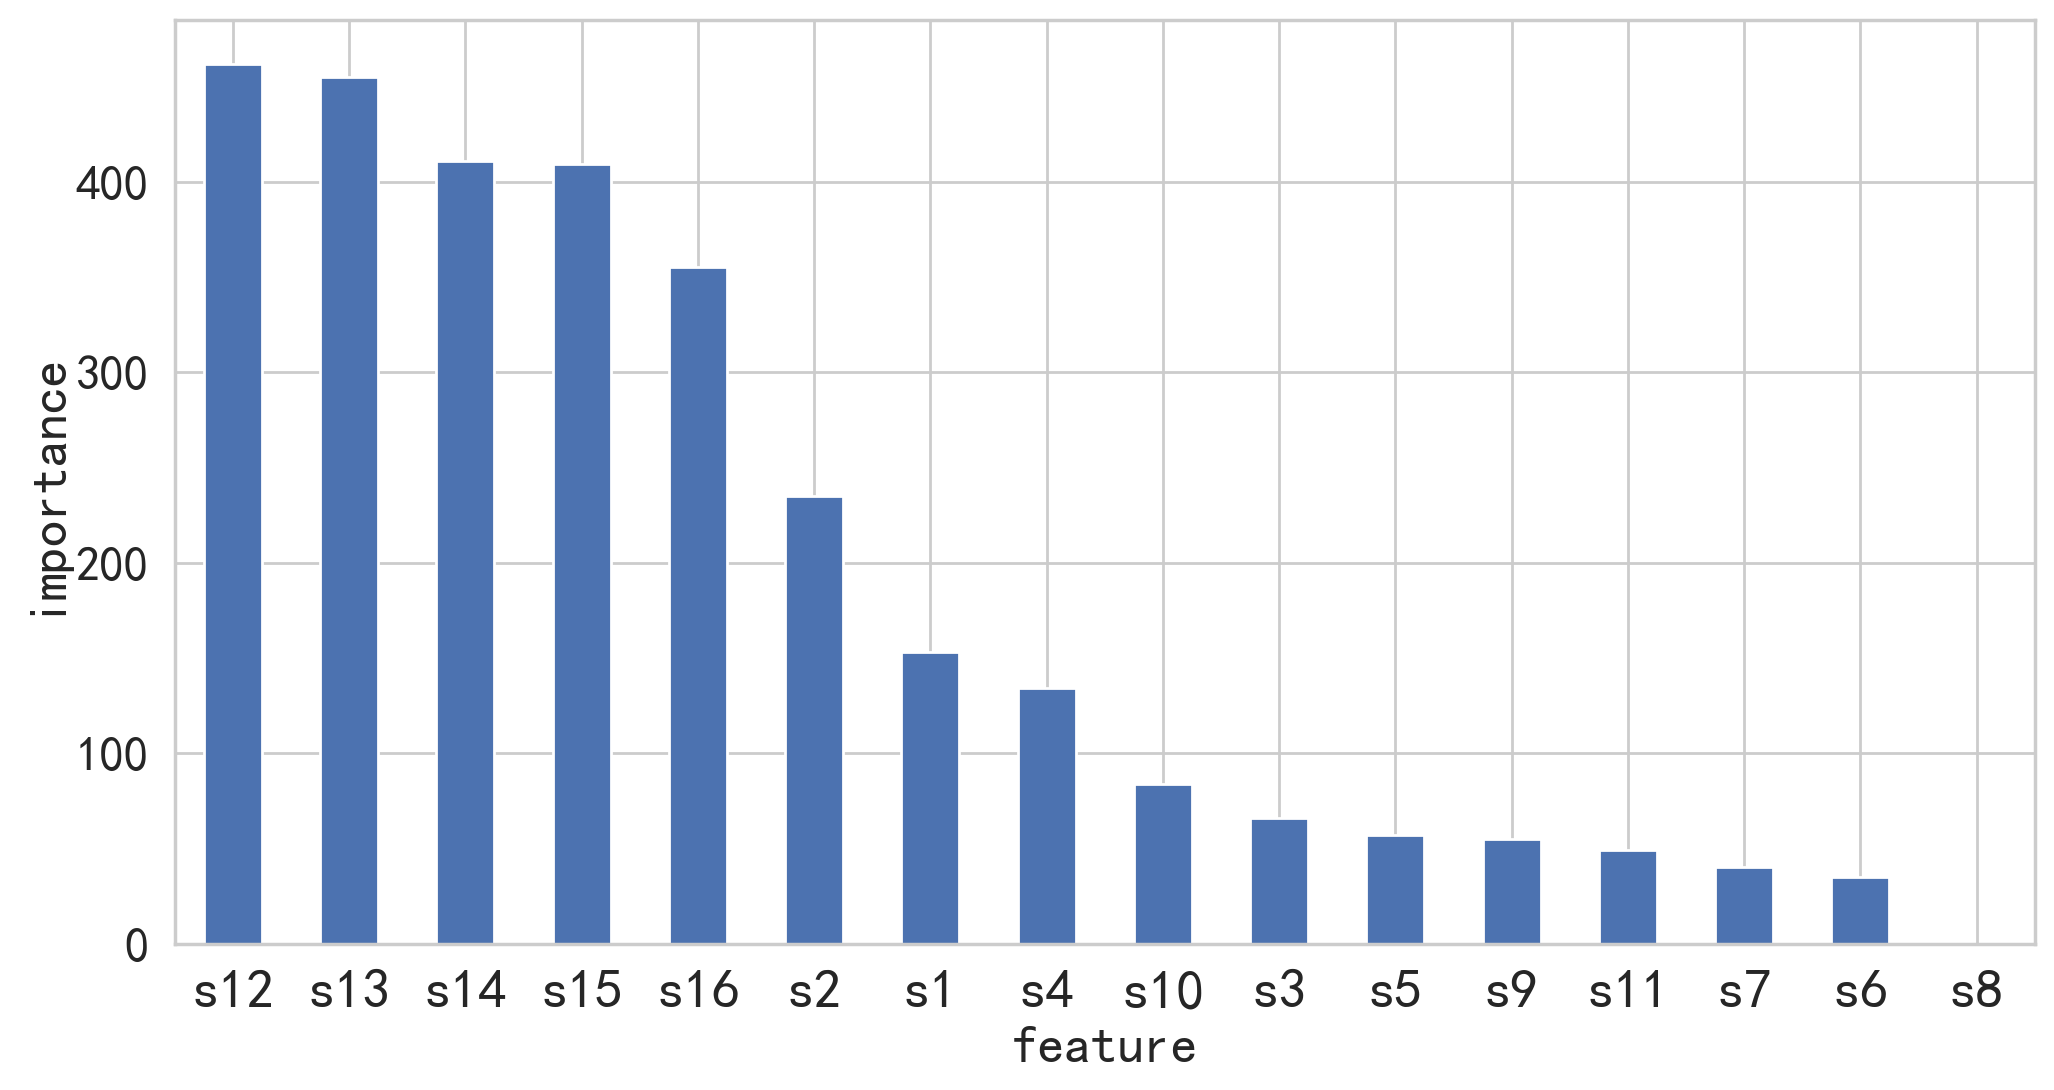

In [58]:
## import the used libraries
%config InlineBackend.figure_format = 'retina'
%matplotlib inline    
import seaborn as sns 
sns.set(font= "simhei",style="whitegrid",font_scale=1.6)
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False # 解决坐标轴的负号显示问题
import matplotlib.pyplot as plt
import plotly.express as px

#输出重要性得分
f = pd.DataFrame({'col':list(columns),'score':model1.feature_importances_}).sort_values(by='score',ascending=False)
f.index = f['col']
f["score"].plot(kind = "bar",figsize = (12,6)) #颜色,matplotlib
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(rotation = 0,fontsize = 20)
#plt.savefig('task3_image\\feature_imp_score_t3.png',dpi=500,bbox_inches='tight')
plt.show()

#### 在这一基础上，我们重新训练模型，同样使用表现最好的SVC模型，选取 2023 年温布尔登男单决赛中，20 岁的西班牙新星卡洛斯·阿尔卡拉兹击败了 36 岁的诺瓦 克·德约科维奇的经典对局进行实时的表现可视化，选取的选手为Carlos Alcaraz

In [59]:
t = dataset.copy()
t['game'] = [i[:19] for i in t.index]
index = t[t.game=='2023-wimbledon-1701'].reset_index(drop=True).index

test = dataset.reset_index(drop=True).iloc[index]
train = dataset.reset_index(drop=True).drop(index,axis=0)

In [60]:
model = SVC(random_state=50,probability=True)
model.fit(train[columns].values,train['label'].values)
pred = model.predict_proba(test[columns].values)
pred = pd.DataFrame({'real_time_score':pred[:,1]},index=index)


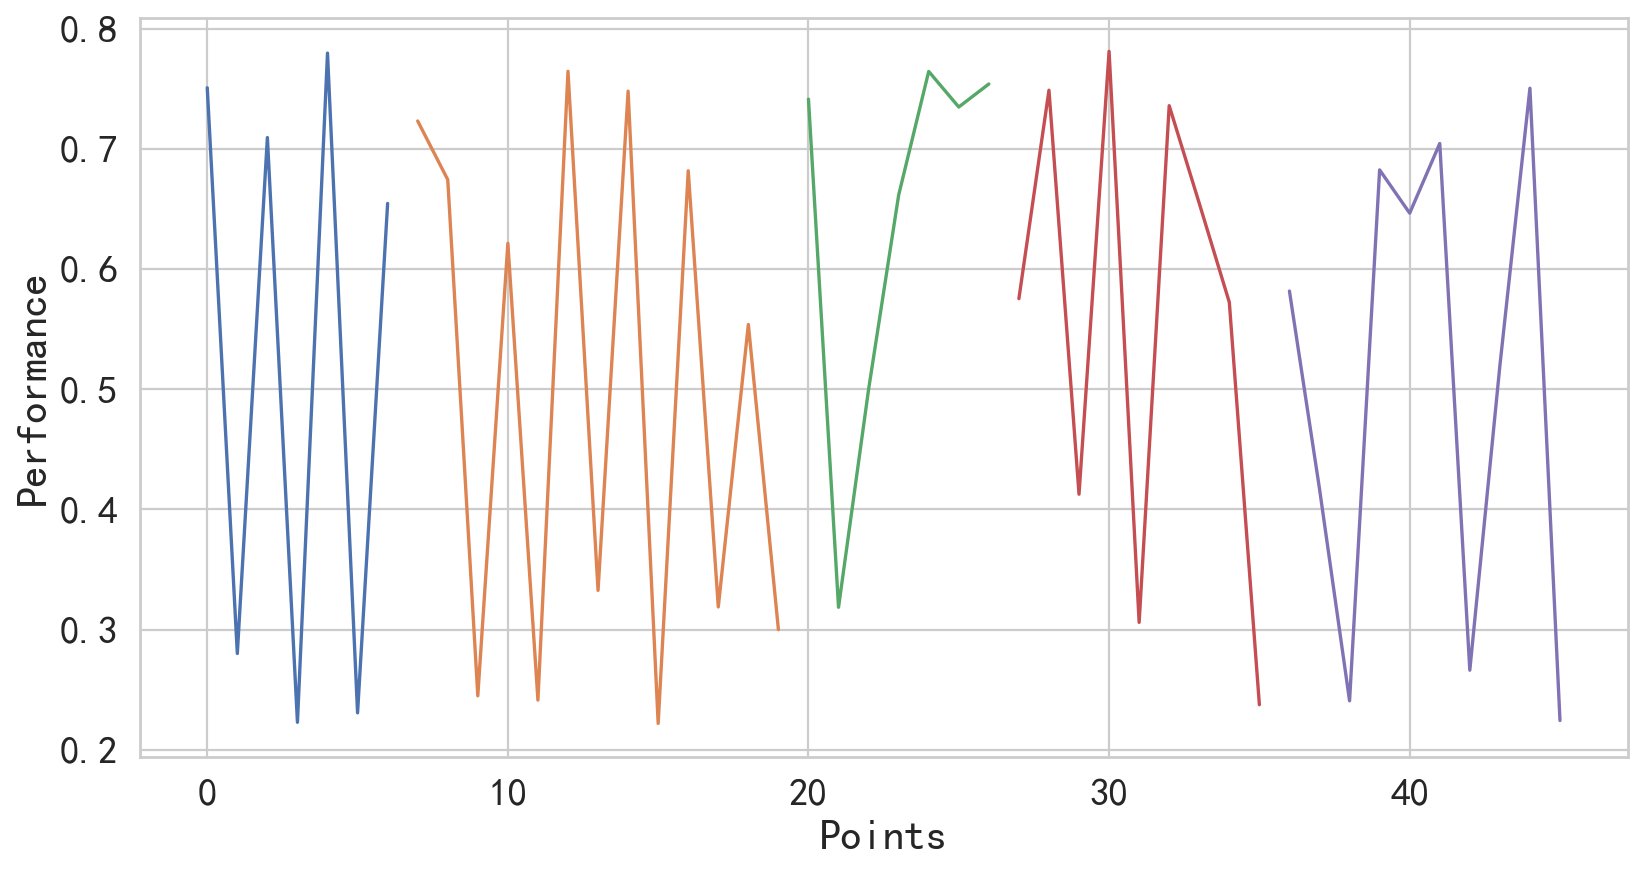

In [61]:
plt.figure(figsize=(12, 6), dpi=80, facecolor='w')

index = t[t.game=='2023-wimbledon-1701'].index

for o in range(5):
    condition = [str(i)[:21] == f'2023-wimbledon-1701-{o+1}' for i in index]
    plt.plot(pred[condition].index,pred[condition].values)


plt.xlabel("Points")
plt.ylabel("Performance")
#plt.savefig('task3_image\\classic_duo_trend_t3.png',dpi=500)
plt.show()

### 由于支持向量机无法在高斯核的前提下计算特征重要性得分，我们采用了信息增益算法进行特征重要性得分计算


In [62]:
dic = {'s1': '当前set中赢得的game数量',
 's2': '本场game的得分领先进度',
 's3': '是否为发球者',
 's4': '上一个point是否得分',
 's5': '本场match的set领先进度',
 's6': '本场game是否发球得分（无触碰）',
 's7': '本场game是否回击得分（无触碰）',
 's8': '本场game是否出现双误',
 's9': '本场game是否出现非强迫失误',
 's10': '上网次数与上网得分比例',
 's11': '本场set内对方发球时获得得分机会与实际获得得分的比例',
 's12': '本场match内总计跑图里程',
 's13': '最近三个point内的总计跑图里程',
 's14': '上一个point跑图里程',
 's15': '发球实时配速',
 's16': '是否为发球者和发球实时配速交互项'}

In [63]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np

# 创建特征数据集X和目标变量y
X = train[columns].values
y = train['label'].values
 
# 将特征数据转换为numpy数组
X = np.array(X)
 
# 计算每个特征的信息增益
ls = []
for i in range(X.shape[1]):
    gain = mutual_info_classif(X[:,i].reshape(-1,1), y)[0]
    ls.append(gain)
    
result = pd.DataFrame({'feature':columns,'name':[dic[i] for i in columns],'score':ls}).sort_values(by='score',ascending=False)
result.to_excel('task3_image\\info_gain_result.xlsx')
result

feature                         name     score
3       s4                 上一个point是否得分  0.084527
1       s2                本场game的得分领先进度  0.080094
6       s7            本场game是否回击得分（无触碰）  0.030904
9      s10                  上网次数与上网得分比例  0.029802
5       s6            本场game是否发球得分（无触碰）  0.015194
10     s11  本场set内对方发球时获得得分机会与实际获得得分的比例  0.010187
0       s1              当前set中赢得的game数量  0.000000
2       s3                       是否为发球者  0.000000
4       s5              本场match的set领先进度  0.000000
7       s8                 本场game是否出现双误  0.000000
8       s9              本场game是否出现非强迫失误  0.000000
11     s12               本场match内总计跑图里程  0.000000
12     s13            最近三个point内的总计跑图里程  0.000000
13     s14                 上一个point跑图里程  0.000000
14     s15                       发球实时配速  0.000000
15     s16             是否为发球者和发球实时配速交互项  0.000000

#### 根据这一结果，可以知道game的得分领先进度最有利于提高选手的表现，然后是上一个point是否得分（均值），这意味着这个选手的手感火热，同时，排在第三的无触碰回击得分也能显示选手的手感

### 问题4： 在一场或多场其他比赛中测试你开发的模型。你对比赛中挥杆的波动有多好?如果模型有时表现不佳，你能识别出任何可能需要纳入未来模型的因素吗?你的模型对其他比赛 (如女子比赛)、锦标赛、球场表面和其他运动(如乒乓球)的泛化程度如何?

#### 具体的，我们随机选取了4场比赛，将这4场比赛作为测试集，其余数据作为训练集，由于“波动”这个指标其实是比较模糊且不好评价的，所以我们仍然利用机器学习的指标进行评价，具体的，对于这四场比赛使用roc-auc进行可视化，然后画出具体的波动情况

In [64]:
name = set([i[:19] for i in dataset.index])
matchcode = pd.DataFrame(name).sample(4)[0].values
matchcode

array(['2023-wimbledon-1504', '2023-wimbledon-1307',
       '2023-wimbledon-1315', '2023-wimbledon-1503'], dtype=object)

In [65]:
name = set([i[:19] for i in dataset.index])


plt.figure(dpi=300,figsize=(24,12))
#ax1.set_ylabel('当雄',labelpad=20)
#ax1.set_xticks([])
n = 1

matchcode = pd.DataFrame(name).sample(4)[0].values
for ccc in matchcode:
    t = dataset.copy()
    t['game'] = [i[:19] for i in t.index]
    index = t[t.game==ccc].reset_index(drop=True).index
    set_number = set([int(i.split('-')[3]) for i in t[t.game==ccc].index.values])
    
    test = dataset.reset_index(drop=True).iloc[index]
    train = dataset.reset_index(drop=True).drop(index,axis=0)

    model = SVC(random_state=50,probability=True)
    model.fit(train[columns].values,train['label'].values)
    pred = model.predict_proba(test[columns].values)
    pred = pd.DataFrame({'real_time_score':pred[:,1]},index=index)


    
    ax1 = plt.subplot(int(f'22{n}'))
    #plt.figure(figsize=(12, 6), dpi=80, facecolor='w')
    index = t[t.game==ccc].index
    for o in set_number:
        condition = [str(i)[:21] == f'{ccc}-{o}' for i in index]
        plt.plot(pred[condition].index,pred[condition].values,linestyle='-',marker='*')
    plt.title(ccc)
    if n == 3 or n ==4:
        ax1.set_xlabel('Points')
    ax1.set_ylabel('Performance')
    #plt.xlabel("Points")
    #plt.ylabel("Performance")
    
    #plt.show()
    n+=1
#plt.savefig('问题4\\问题4随机四个比赛的波动效果.png',dpi=500)

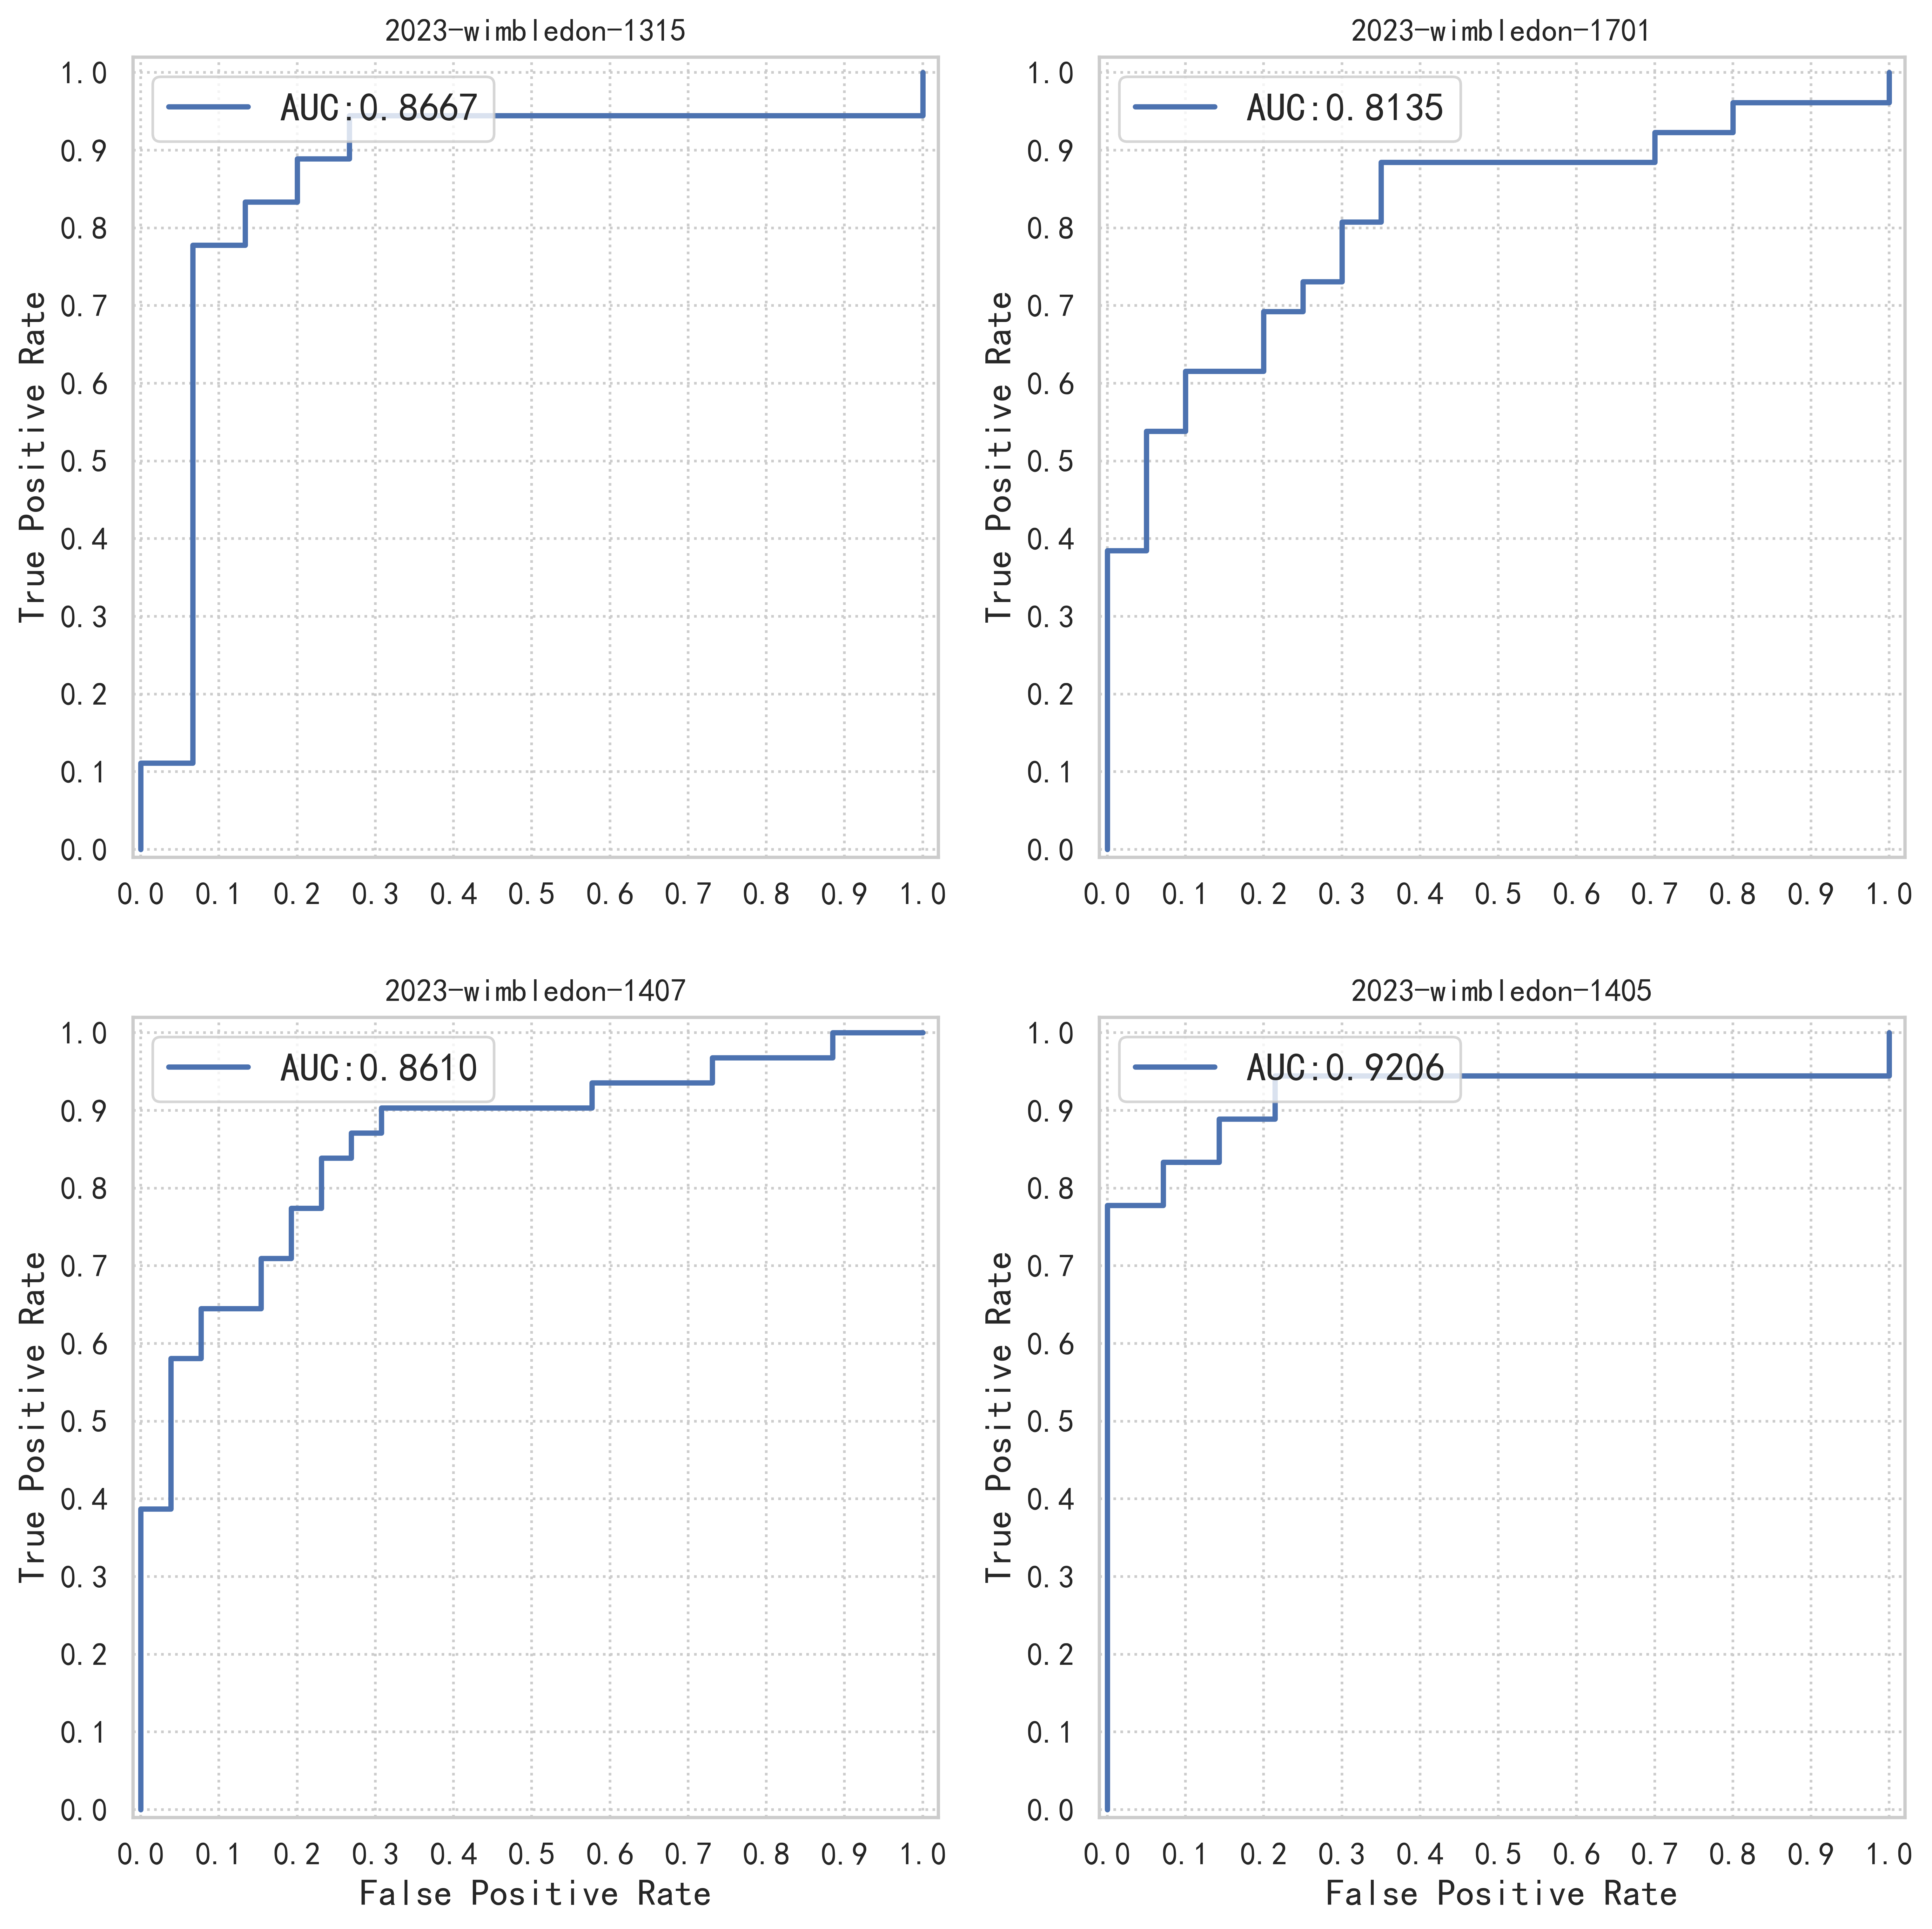

In [66]:
name = set([i[:19] for i in dataset.index])


plt.figure(dpi=300,figsize=(12,12))
#ax1.set_ylabel('当雄',labelpad=20)
#ax1.set_xticks([])
n = 1

matchcode = pd.DataFrame(name).sample(4)[0].values
for ccc in matchcode:
    t = dataset.copy()
    t['game'] = [i[:19] for i in t.index]
    index = t[t.game==ccc].reset_index(drop=True).index
    set_number = set([int(i.split('-')[3]) for i in t[t.game==ccc].index.values])
    
    test = dataset.reset_index(drop=True).iloc[index]
    train = dataset.reset_index(drop=True).drop(index,axis=0)

    model = SVC(random_state=50,probability=True)
    model.fit(train[columns].values,train['label'].values)
    pred = model.predict_proba(test[columns].values)
    pred = pd.DataFrame({'real_time_score':pred[:,1]},index=index)

    ax1 = plt.subplot(int(f'22{n}'))
    plt.xlim((-0.01, 1.02))  # x,y 轴刻度的范围
    plt.ylim((-0.01, 1.02))
    plt.xticks(np.arange(0, 1.1, 0.1))  #绘制刻度
    plt.yticks(np.arange(0, 1.1, 0.1))

    ytest_prob = model.predict_proba(test[columns].values)[:,1]
    fpr, tpr, _ = metrics.roc_curve(test['label'].values, ytest_prob)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, '-', lw=2, label=f'AUC:%.4f' % auc)  # 绘制AUC 曲线
    plt.title(ccc,size=12)

    plt.legend(loc='upper left',fontsize=15)    # 设置显示标签的位置
    if n == 3 or n ==4:
        plt.xlabel('False Positive Rate', fontsize=14)   #绘制x,y 坐标轴对应的标签
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.tick_params(labelsize=12)

    plt.grid(True, ls=':')  # 绘制网格作为底板;b是否显示网格线；ls表示line style
    #plt.savefig(f'task3_image\\roc_auc({types}(before_sampling_t3)).png',dpi=500)
    #plt.show()
    n+=1
#plt.savefig('问题4\\问题4随机四个比赛的ROC曲线.png',dpi=500)

#### 所以可以看到，比赛与比赛之前是存在明显差异的，甚至对于某些比赛的auc可以达到0.9以上，这说明模型的效果已经很不错了，但是，对于一些比赛，又会存在0.7多一点的auc值，这意味着模型在某些比赛上的表现是不够好的。

### 关于模型表现不佳问题，本文认为其实提出的指标体系是有一定缺陷的，这一缺陷主要来自于模型对于选手并不具有先验知识，因此对于两个选手刚开始进行比赛的时候，模型的预测可能是不够精准的，因为此刻模型并不知道哪个选手的能力更加突出，而随着时间的推移，由于模型已经获取到两个选手的实时比赛情况，例如能力比较强的选手大概率他的比赛set和game得分也是高于能力弱的选手的，这时模型就通过后验知识能够在后面的比赛中预测逐渐变得精准。
### 因此，如果在考虑纳入未来模型的因素的话，一个十分重要的因素就是选手的个人能力，而这一般可以通过选手在过去的比赛中的表现得到，

### 例如，我们在指标体系的基础上进行扩展，将选手的能力根据今年比赛的成绩来分类，以每个选手赢得的总计set数量为依据，得到每个选手的能力指标和对手能力指标

#### 每个选手的得分总数（能力）

In [67]:
player_ability = {}
#player1
for player in df.player1.unique():
    total_score = 0
    t = df[df.player1==player]
    for match_id in t.match_id.unique():
        t1 = t[t.match_id==match_id]
        for set_no in t1.set_no.unique():
            t2 = t1[t1.set_no==set_no]
            for game_no in t2.game_no.unique():
                t3 = t2[t2.game_no==game_no]
                if t3['game_victor'].values[-1] == 1:
                    total_score += 1
    player_ability[player] = total_score
#player2
for player in df.player2.unique():
    total_score = 0
    t = df[df.player2==player]
    for match_id in t.match_id.unique():
        t1 = t[t.match_id==match_id]
        for set_no in t1.set_no.unique():
            t2 = t1[t1.set_no==set_no]
            for game_no in t2.game_no.unique():
                t3 = t2[t2.game_no==game_no]
                if t3['game_victor'].values[-1] == 0:
                    total_score += 1
    player_ability[player] = total_score

player_ability


{'Carlos Alcaraz': 103,
 'Alexander Zverev': 15,
 'Frances Tiafoe': 7,
 'Alejandro Davidovich Fokina': 25,
 'Daniil Medvedev': 1,
 'Jiri Lehecka': 1,
 'Christopher Eubanks': 3,
 'Laslo Djere': 14,
 'Jannik Sinner': 71,
 'Denis Shapovalov': 3,
 'Andrey Rublev': 68,
 'Alexander Bublik': 5,
 'Lorenzo Musetti': 14,
 'Stan Wawrinka': 10,
 'Grigor Dimitrov': 0,
 'Roman Safiullin': 1,
 'Hubert Hurkacz': 1,
 'Nicolas Jarry': 1,
 'Matteo Berrettini': 4,
 'Holger Rune': 6,
 'Marton Fucsovics': 1,
 'Tommy Paul': 3,
 "Christopher O'Connell": 2,
 'Stefanos Tsitsipas': 5,
 'Quentin Halys': 1,
 'Liam Broady': 1,
 'David Goffin': 2,
 'Maximilian Marterer': 1,
 'Novak Djokovic': 7,
 'Daniel Elahi Galan': 1}

In [68]:
code = []

s1_ls,s2_ls,s3_ls,s4_ls,s5_ls,s6_ls,s7_ls,s8_ls,s9_ls,s10_ls,s11_ls,\
s12_ls,s13_ls,s14_ls,s15_ls,s16_ls=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
label_ls = []

myability,confability = [],[]
for match_id in df.match_id.unique():
    t = df[df.match_id==match_id]
    for set_no in t.set_no.unique():
        t2 = t[t.set_no==set_no]
        for game_no in t2.game_no.unique():
            t3 = t2[t2.game_no==game_no]
            if t3['game_victor'].values[-1] == 1:
                label_ls.append(1)
            else:
                label_ls.append(0)                
                
for match_id,set_no,game_no,point_no in zip(df.match_id,df.set_no,df.game_no,df.point_no):
    code.append(f'{match_id}-{set_no}-{game_no}')
    match = df[df.match_id==match_id]
    set_ = match[match.set_no==set_no]
    game_ = set_[set_.game_no==game_no]
    point_ = game_[game_.point_no==point_no]
    s1 = point_['p1_games'].values[0]
    s2 = point_['p1_score'].values[0] - point_['p2_score'].values[0]
    s3 = 1 if point_['serve_no'].values[0] == 1 else 0
    s4 = 0 if s2<0 else 1
    s5 = point_['p1_sets'].values[0] - point_['p2_sets'].values[0]
    s6 = 1 if 1 in game_['p1_ace'].values else 0
    s7 = 1 if 1 in game_['p1_winner'].values else 0
    s8 = 1 if 1 in game_['p1_double_fault'].values else 0
    s9 = 1 if 1 in game_['p1_unf_err'].values else 0
    s10 = game_['p1_net_pt_won'].sum()/game_['p1_net_pt'].sum() if game_['p1_net_pt'].sum()!= 0 else 0
    s11 = set_['p1_break_pt_won'].sum()/set_['p1_break_pt'].sum() if game_['p1_break_pt'].sum()!= 0 else 0

    index = match.index.tolist().index(point_.index.tolist()[0])
    s12 = match.iloc[:index+1]['p1_distance_run'].sum()
    s13 = match.iloc[index-2:index+1]['p1_distance_run'].sum()
    s14 = point_['p1_distance_run'].values[0]
    s15 = point_['speed_mph'].values[0]
    s16 = s15*s3

    s1_ls.append(s1)
    s2_ls.append(s2)
    s3_ls.append(s3)
    s4_ls.append(s4)
    s5_ls.append(s5)
    s6_ls.append(s6)
    s7_ls.append(s7)
    s8_ls.append(s8)
    s9_ls.append(s9)
    s10_ls.append(s10)
    s11_ls.append(s11)
    s12_ls.append(s12)
    s13_ls.append(s13)
    s14_ls.append(s14)
    s15_ls.append(s15)
    s16_ls.append(s16)
    
    myability.append(player_ability[point_['player1'].values[0]])
    confability.append(player_ability[point_['player2'].values[0]])
    
dataset1 = pd.DataFrame({'s1':s1_ls,'s2':s2_ls,'s3':s3_ls,'s4':s4_ls,'s5':s5_ls,'s6':s6_ls,'s7':s7_ls,'s8':s8_ls,'s9':s9_ls,'s10':s10_ls,'s11':s11_ls,'s12':s12_ls,'s13':s13_ls,'s14':s14_ls,'s15':s15_ls,'s16':s16_ls,'myability':myability,'confability':confability})
dataset1['game_code'] = code
dataset1

s1  s2  s3  s4  s5  s6  s7  s8  s9  s10  s11       s12     s13     s14  \
0      0   0   0   1   0   1   1   0   1  1.0  0.0     6.000   0.000   6.000   
1      0 -15   1   0   0   1   1   0   1  1.0  0.0    11.253   0.000   5.253   
2      0   0   1   1   0   1   1   0   1  1.0  0.0    25.053  25.053  13.800   
3      0 -15   1   0   0   1   1   0   1  1.0  0.0    76.161  70.161  51.108   
4      0   0   1   1   0   1   1   0   1  1.0  0.0    76.810  65.557   0.649   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...       ...     ...     ...   
6219   5 -15   1   0   0   0   1   0   1  1.0  0.0  6270.624  49.542  38.620   
6220   5   0   1   1   0   0   1   0   1  1.0  0.0  6288.157  62.925  17.533   
6221   5  15   1   1   0   0   1   0   1  1.0  0.0  6299.039  67.035  10.882   
6222   5   0   1   1   0   0   1   0   1  1.0  0.0  6306.932  36.308   7.893   
6223   5  10   1   1   0   0   1   0   1  1.0  0.0  6324.743  36.586  17.811   

        s15    s16  myability  confability                 game_code  
0      95.0    0.0        103            1   2023-wimbledon-1301-1-1  
1     118.0  118.0        103            1   2023-wimbledon-1301-1-1  
2     120.0  120.0        103            1   2023-wimbledon-1301-1-1  
3     130.0  130.0        103            1   2023-wimbledon-1301-1-1  
4     112.0  112.0        103            1   2023-wimbledon-1301-1-1  
...     ...    ...        ...          ...                       ...  
6219  123.0  123.0        103            7  2023-wimbledon-1701-5-10  
6220  114.0  114.0        103            7  2023-wimbledon-1701-5-10  
6221  124.0  124.0        103            7  2023-wimbledon-1701-5-10  
6222  130.0  130.0        103            7  2023-wimbledon-1701-5-10  
6223  129.0  129.0        103            7  2023-wimbledon-1701-5-10  

[6224 rows x 19 columns]

In [69]:
columns = dataset1.columns[:-2]

dataset = dataset1.groupby('game_code').mean()
dataset['label'] = label_ls

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns = dataset.columns[:-1]
scaler.fit(dataset[columns].values)
dataset[columns] = scaler.transform(dataset[columns].values)
dataset


s1        s2        s3    s4   s5   s6   s7  \
game_code                                                                    
2023-wimbledon-1301-1-1  0.000000  0.451613  0.700000  0.76  0.5  1.0  1.0   
2023-wimbledon-1301-1-2  0.166667  0.403226  0.875000  0.55  0.5  0.0  0.0   
2023-wimbledon-1301-1-3  0.166667  0.780645  0.800000  1.00  0.5  1.0  1.0   
2023-wimbledon-1301-1-4  0.333333  0.040323  0.750000  0.10  0.5  0.0  0.0   
2023-wimbledon-1301-1-5  0.333333  0.766129  0.625000  1.00  0.5  0.0  1.0   
...                           ...       ...       ...   ...  ...  ...  ...   
2023-wimbledon-1701-5-5  0.500000  0.025806  0.600000  0.04  0.5  0.0  0.0   
2023-wimbledon-1701-5-6  0.500000  0.387097  0.500000  0.60  0.5  1.0  1.0   
2023-wimbledon-1701-5-7  0.666667  0.322581  0.833333  0.40  0.5  0.0  1.0   
2023-wimbledon-1701-5-8  0.666667  0.548387  0.400000  0.76  0.5  1.0  1.0   
2023-wimbledon-1701-5-9  0.833333  0.025806  0.800000  0.04  0.5  0.0  0.0   

                          s8   s9  s10  s11       s12       s13       s14  \
game_code                                                                   
2023-wimbledon-1301-1-1  0.0  1.0  1.0  0.0  0.010922  0.272646  0.211272   
2023-wimbledon-1301-1-2  0.0  0.0  0.0  0.0  0.033335  0.274109  0.148779   
2023-wimbledon-1301-1-3  0.0  0.0  0.0  0.0  0.044895  0.282164  0.188211   
2023-wimbledon-1301-1-4  0.0  1.0  0.0  0.0  0.055108  0.267586  0.157843   
2023-wimbledon-1301-1-5  0.0  1.0  1.0  0.0  0.065767  0.235225  0.150174   
...                      ...  ...  ...  ...       ...       ...       ...   
2023-wimbledon-1701-5-5  0.0  0.0  0.0  0.0  0.938366  0.157842  0.139101   
2023-wimbledon-1701-5-6  0.0  0.0  1.0  0.0  0.950200  0.264636  0.140105   
2023-wimbledon-1701-5-7  0.0  0.0  0.0  0.0  0.962810  0.345894  0.234750   
2023-wimbledon-1701-5-8  0.0  1.0  0.0  0.0  0.976140  0.260887  0.142916   
2023-wimbledon-1701-5-9  0.0  0.0  0.0  0.0  0.986833  0.285519  0.180057   

                              s15       s16  myability  confability  label  
game_code                                                                   
2023-wimbledon-1301-1-1  0.562963  0.608088        1.0     0.142857      1  
2023-wimbledon-1301-1-2  0.696759  0.790441        1.0     0.142857      0  
2023-wimbledon-1301-1-3  0.692593  0.726471        1.0     0.142857      1  
2023-wimbledon-1301-1-4  0.652778  0.665441        1.0     0.142857      0  
2023-wimbledon-1301-1-5  0.550926  0.533088        1.0     0.142857      1  
...                           ...       ...        ...          ...    ...  
2023-wimbledon-1701-5-5  0.611111  0.541176        1.0     1.000000      1  
2023-wimbledon-1701-5-6  0.611111  0.453431        1.0     1.000000      0  
2023-wimbledon-1701-5-7  0.623457  0.721814        1.0     1.000000      1  
2023-wimbledon-1701-5-8  0.414815  0.333824        1.0     1.000000      0  
2023-wimbledon-1701-5-9  0.522222  0.664706        1.0     1.000000      1  

[1108 rows x 19 columns]

### 判断选手个人能力和对手能力与label是否具有相关性

In [70]:
import scipy.stats as stats
 
# 定义两组变量

# 计算Pearson相关系数
corr_coef, p_value = stats.pearsonr(dataset['myability'], dataset['label'])
print("Personal ability's Pearson correlation coefficient:", round(corr_coef,3))
print("p value:", p_value)

# 计算Pearson相关系数
corr_coef, p_value = stats.pearsonr(dataset['confability'], dataset['label'])
print("Competitiors ability's Pearson correlation coefficient:", round(corr_coef,3))
print("p value:", p_value)

Personal ability's Pearson correlation coefficient: 0.054
p value: 0.07443351631656095
Competitiors ability's Pearson correlation coefficient: -0.074
p value: 0.01387097142990123


#### 虽然个人能力不显著，但也接近于0.05，因此能力因素也是直观重要的

#### 然后建立个人能力与对手能力与label之间的线性回归，发现基本是显著的，说明这两个因素也是非常重要的

In [71]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm


y = dataset['label']
x = dataset[['myability','confability']]
X = sm.add_constant(x)
model = OLS(y,X,fit_intercept=True).fit()
print(model.summary()) 


                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     4.956
Date:                Mon, 05 Feb 2024   Prob (F-statistic):            0.00720
Time:                        16:30:24   Log-Likelihood:                -799.23
No. Observations:                1108   AIC:                             1604.
Df Residuals:                    1105   BIC:                             1619.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5311      0.030     17.514      

c:\Users\Transfer.DAVIDSG15\.conda\envs\mcm24\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['fit_intercept']
  warnings.warn(msg, ValueWarning)
